In [1]:
from itertools import chain
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from fastai.callback.wandb import *
from fastai.vision.all import *

from FastFF.models.general import *
from FastFF.utils import *

In [2]:
sweep_cfg = {
    'method': 'grid',
    'metric': {'name': 'valid_loss', 'goal': 'minimize'},
    'parameters': {
        'dataset': {'value': 'CIFAR10'},
        'bs': {'value': 128},
        'learn': {'parameters': {'lr_max': {'value': 8e-4}}},
        'model': {'parameters': {
            'h': {'values': [8, 16]},
            'd': {'values': [2, 3, 4]},
            'act': {'value': 'relu'},
            'model_type': {'values': ['fff-soft', 'fff']},
            'gate_act': {'values': ['relu', 'linear', 'softplus']}
        }},
        'epochs': {'value': 8}
    }
}


def run(cfg, run):
    acts = {'relu': nn.ReLU(), 'softplus': nn.Softplus(), 'linear': nn.Identity()}
    run.name = ' '.join(f'{k}={v}' for k, v in cfg.model.items())
    h, d = cfg.model['h'], cfg.model['d']
    in_dim, out_dim = 32*32*3, 10
    if cfg.model['model_type'] == 'fff-soft':
        model = GeneralMoE(GateFFF(in_dim, d, acts[cfg.model['gate_act']]),
                           SoftMergingExperts(2**d, in_dim, out_dim, h), save_probs=True)
    elif cfg.model['model_type'] == 'fff':
        model = GeneralMoE(GateFFF(in_dim, d, acts[cfg.model['gate_act']]),
                           TopkExperts(2**d, in_dim, out_dim, h), save_probs=True)

    cbs = [TinyWandbCallback(log_preds=False), ProbsDistrCB(wandb=True, sample_size=100, image_shape=(3,32,32))]
    learn = Learner(get_cifar_dls(cfg.bs), model, F.cross_entropy, metrics=accuracy, cbs=cbs)
    learn.fit_one_cycle(cfg.epochs, lr_max=cfg.learn['lr_max'])

In [ ]:
runs_sweep(sweep_cfg, 'FFF', 24, "Activations", sweep_id='ky8261s9')(run)

## Visualize the results

In [1]:
import wandb

api = wandb.Api()
sweep = api.sweep("slakter/FFF/sweeps/ky8261s9")

In [2]:
sweep0 =  api.sweep("slakter/FFF/sweeps/5yb9x2nq")
runs = []
for run in sweep0.runs:
    cfg = run.config['model']
    if cfg['model_type'] in ['fff', 'fff-soft'] and cfg['d']>1 and cfg['h']<32:
        run.config['model']['gate_act'] = 'softplus'
        runs.append(run)

In [9]:
params = ['d', 'h']
metrics = ['train_loss', 'valid_loss', 'accuracy']


def get_metrics(runs, model='fff-soft', fixed=None):
    if fixed is None: fixed = {}
    acts = {'linear': [], 'relu': [], 'softplus': []}
    params = ['d', 'h']
    for run in runs:
        cfg = run.config['model']
        if (cfg['model_type'] != model) or any(cfg[p] != v for p, v in fixed.items()): 
            continue
        m = cfg['gate_act']
        res = {k: summary(run)[k] for k in metrics}
        for p in params: res[p] = cfg[p]
        acts[m].append(res)
    return acts


def summary(run):
    if hasattr(run, 'metrics'): return run.metrics
    return run.summary


def plot_summary(fixed, axes, runs, model='fff-soft'):
    acts = get_metrics(runs, model, fixed)
    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.set_title(f'')
        ax.grid()
        ax.set_label(metric)
        ax.set_xlabel('d')
        ax.set_ylabel(metric)
        for m, l in acts.items():
            xs = list(map(lambda x: x['d'], l))
            ys = list(map(lambda x: x[metric], l))
            ax.plot(xs, ys, label=m)
            ax.scatter(xs, ys)

In [15]:
import numpy as np
def merge_dicts(d1, d2, metric, common=['d', 'h']):
    return [{metric: (x[metric], y[metric])} 
            for x in d1 for y in d2 
            if all(x[c] == y[c] for c in common)]

def get_mean(l, metric):
    return np.mean([(x[metric][1]-x[metric][0])/x[metric][0] for x in l])

In [23]:
m = get_metrics(chain(runs,sweep.runs),  model='fff-soft')

In [25]:
a = merge_dicts(m['softplus'], m['relu'], 'accuracy')
get_mean(a, 'accuracy')*100

3.939504244196895

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({'font.size': 20})

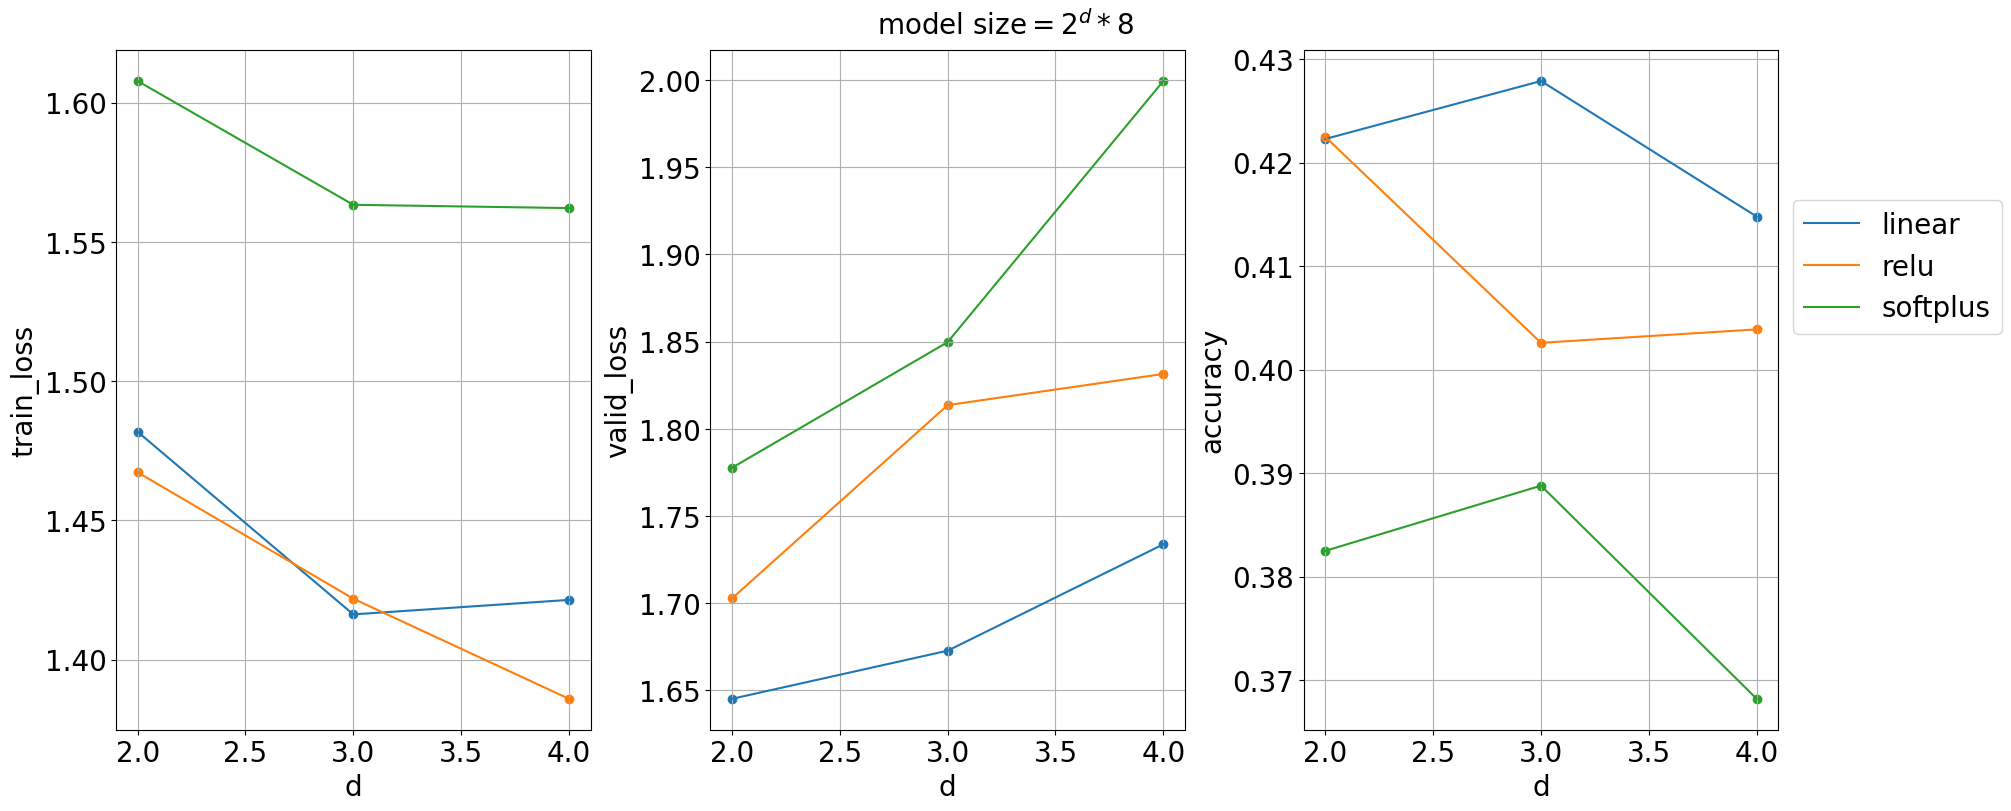

In [13]:
hs = 8
fig = plt.figure(constrained_layout=True, figsize=(20,8))
fig.suptitle(f'$\\text{{model size}}=2^d*{hs}$',size=20)
axes = fig.subplots(ncols=len(metrics))
plot_summary({'h': hs}, axes, chain(runs,sweep.runs), model='fff')
plt.legend(bbox_to_anchor=(1.5, 0.8))